In [1]:
"""
Parts of this code was adapted from: https://github.com/GuillaumeErhard/Supervised_contrastive_loss_pytorch
"""
import argparse
import math
import numpy as np
import os
import torch

from torch.backends import cudnn
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

from utils import progress_bar
from loss.spc import SupervisedContrastiveLoss
from data_augmentation.auto_augment import AutoAugment
from data_augmentation.duplicate_sample_transform import DuplicateSampleTransform

from models.cnn_contrastive import get_cnn_contrastive
import random
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
seed = 37
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


class Args:
    def __init__(self):
        self.batch_size = 512  # Batch size for training
        self.temperature = 0.07  # Temperature constant for contrastive loss
        self.auto_augment = False  # Whether to apply AutoAugment during training
        self.n_epochs_contrastive = 500  # Number of epochs for contrastive training
        self.n_epochs_cross_entropy = 50  # Number of epochs for cross-entropy training
        self.lr_contrastive = 1e-1  # Learning rate for contrastive step
        self.lr_cross_entropy = 5e-2  # Learning rate for cross-entropy step
        self.cosine = True  # Whether to use cosine annealing for learning rate
        self.lr_decay_rate = 0.1  # Learning rate decay rate when cosine is not used
        self.lr_decay_epochs = [150, 300, 500]  # Epochs to decay learning rate
        self.weight_decay = 1e-4  # Weight decay for optimizer
        self.momentum = 0.9  # Momentum for SGD optimizer
        self.num_workers = 4  # Number of workers for data loading

args = Args()

def add_awgn_noise(z, snr_db):
    # Calculate the signal power
    signal_power = torch.mean(torch.abs(z**2))
    
    # Calculate noise power based on the SNR
    sigma2 = signal_power * 10**(-snr_db/10)
    
    # Generate real noise using torch.randn
    noise = torch.sqrt(sigma2) * torch.randn(z.size(), dtype=z.dtype, device=z.device)
    
    # Return the signal plus the noise (real-valued)
    return z + noise

In [2]:
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Predefined background colors (RGB values between 0 and 1)
predefined_bg_colors = {
    "red": np.array([1, 0, 0]),
    "green": np.array([0, 1, 0]),
    "blue": np.array([0, 0, 1]),
    "yellow": np.array([1, 1, 0]),
    "purple": np.array([1.0, 0, 1.0]),
    "light blue": np.array([0, 1, 1]),
    "black": np.array([0, 0, 0]),
}

# Convert the dictionary to lists for easier access
color_names = list(predefined_bg_colors.keys())
color_values = np.array(list(predefined_bg_colors.values()))

class ColoredFashionMNIST(Dataset):
    def __init__(self, fashion_mnist_data, bg_colors, contrastive=False):
        self.fashion_mnist_data = fashion_mnist_data
        self.bg_colors = bg_colors  # Use predefined background colors
        self.contrastive = contrastive  # Flag to control if it's contrastive or classification

    def __len__(self):
        return len(self.fashion_mnist_data)

    def colorize_image(self, img, idx):
        img = img.squeeze(0)  # Convert from [1, 28, 28] to [28, 28]
        bg_color = self.bg_colors[idx]
        img_colored = torch.zeros(3, 28, 28)  # Initialize an RGB image

        # Apply the background color to each RGB channel
        for i in range(3):  # Apply background color to each channel
            img_colored[i] = img * 1 + (1 - img) * bg_color[i]  # Keep digit white, color background

        return img_colored

    def __getitem__(self, idx):
        if self.contrastive:
            # For contrastive learning: return two augmented views
            (img1, img2), label = self.fashion_mnist_data[idx]  # img1 and img2 are augmented versions

            # Apply colorization to both augmented images
            img1_colored = self.colorize_image(img1, idx)
            img2_colored = self.colorize_image(img2, idx)

            return (img1_colored, img2_colored), label
        else:
            # For classification: return a single image and label
            img, label = self.fashion_mnist_data[idx]  # Only one image for classification

            # Apply colorization to the image
            img_colored = self.colorize_image(img, idx)

            return img_colored, label

def load_dataset():    
    # Define transformations for the training dataset
    transform_train = [
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip(),
    ]
    if args.auto_augment:
        transform_train.append(AutoAugment())
    transform_train.extend([
        transforms.ToTensor(),
        #transforms.Normalize(mean, std),  # Normalize after applying random transforms
    ])
    transform_train = transforms.Compose(transform_train)

    # Define transformations for the test dataset
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean, std),
    ])

    # Load FashionMNIST dataset without applying transformations initially
    train_set = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform_train)
    num_samples = len(train_set)

    # Randomly assign predefined background colors for the training dataset
    bg_color_indices_train = np.random.randint(0, len(predefined_bg_colors), size=num_samples)
    bg_colors_train = color_values[bg_color_indices_train]  # Get RGB values from predefined colors

    # Create the colorized dataset with transformations applied before colorization
    train_dataset = ColoredFashionMNIST(train_set, bg_colors=bg_colors_train, contrastive=False)

    # Create DataLoader for the training set
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
    )

    # Same process for the test set
    test_set = torchvision.datasets.FashionMNIST(root="../data", train=False, download=True, transform=transform_test)
    bg_color_indices_test = np.random.randint(0, len(predefined_bg_colors), size=len(test_set))
    bg_colors_test = color_values[bg_color_indices_test]  # Background colors for test set
    
    test_dataset = ColoredFashionMNIST(test_set, bg_colors=bg_colors_test, contrastive=False)

    # Create DataLoader for the test set
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
    )

    num_classes = 10
    return num_classes, train_loader, test_loader, transform_train, bg_colors_train


In [6]:
num_classes, train_loader, test_loader, transform_train, bg_colors_train = load_dataset()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, Independent
class ReconstructorX(nn.Module):
    def __init__(self, input_dim, output_dim, y_dim, num_classes):
        super(ReconstructorX, self).__init__()
        # Initialize a learnable dictionary of class embeddings
        self.class_embeddings = nn.Parameter(torch.randn(num_classes, y_dim))
        
        # Fully connected block
        self.fc = nn.Sequential(
            nn.Linear(input_dim + y_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, z, y=None):
        combined = torch.cat((z, y), dim=1)
        return self.fc(combined)

def get_spectral_norm(layer):
    return nn.utils.spectral_norm(layer)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, a=0.2)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
class Discriminator(nn.Module):
    def __init__(self, z_s_dim, z_t_dim, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.fc_z_s = get_spectral_norm(nn.Linear(in_features=z_s_dim, out_features=128, bias=True))
        self.fc_z_t = get_spectral_norm(nn.Linear(in_features=z_t_dim, out_features=128, bias=True))
        
        self.fc_blocks = nn.Sequential(
            # Layer 1
            get_spectral_norm(nn.Linear(in_features=256, out_features=hidden_dim, bias=True)),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # Layer 2
            get_spectral_norm(nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=True)),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # Layer 3
            get_spectral_norm(nn.Linear(in_features=hidden_dim, out_features=1, bias=True)),
            nn.Sigmoid()  # Output a probability
        )
        
        # 2. Initialize weights
        self.apply(init_weights)

    def _call_method(self, z_s, z_t):
        z_s_emb = self.fc_z_s(z_s)
        z_t_emb = self.fc_z_t(z_t)
        combined = torch.cat([z_s_emb, z_t_emb], dim=1)
        return self.fc_blocks(combined)

    def forward(self, z_s, z_t, mode='orig'):
        assert mode in ['orig', 'perm']
        
        if mode == 'orig':
            return self._call_method(z_s, z_t)
        else:  # mode == 'perm'
            # Permuting z_s and z_t embeddings across the batch
            z_s_permed = z_s[torch.randperm(z_s.size(0)).to(z_s.device)]
            z_t_permed = z_t[torch.randperm(z_t.size(0)).to(z_t.device)]
            return self._call_method(z_s, z_t_permed)

class CNNEncoder2(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(CNNEncoder2, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)  # Conv layer with 32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # Conv layer with 64 filters
        self.fc_mu = nn.Linear(64 * 14 * 14, latent_dim)  # Fully connected layer for mean
        self.fc_sigma = nn.Linear(64 * 14 * 14, latent_dim)  # Fully connected layer for std dev

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output from conv layers
        z2_mu = self.fc_mu(x)
        z2_sigma = F.softplus(self.fc_sigma(x)) + 1e-7  # Ensure non-zero variance
        z = self.reparameterize(z2_mu, z2_sigma)
        return z

    def reparameterize(self, mu, sigma):
        dis = Independent(Normal(loc=mu, scale=sigma), 1)
        return dis.rsample()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   
encoder2 = CNNEncoder2(3, 64).to(device)
projection_layer = nn.Linear(10, 64).to(device)     
reconstructor = ReconstructorX(64, 3*28*28, 64, 10).to(device)
discriminator = Discriminator(64, 64).to(device)
optimizer_recon_y = optim.Adam(list(projection_layer.parameters()) + list(reconstructor.parameters()), lr=1e-3)

In [7]:
# Loss function and optimizer
criterion_reconstruction = nn.MSELoss()
optimizer_E2 = optim.Adam(encoder2.parameters(), lr=1e-3)
optimizer_Recon = optim.Adam(reconstructor.parameters(), lr=1e-3)

# Training loop for phase 1
epochs_phase1 = 30
for epoch in range(epochs_phase1):
    encoder2.train()
    reconstructor.train()
    total_reconstruction_loss = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs_flattened = inputs.view(inputs.size(0), -1)  # Flatten the images
        
        optimizer_E2.zero_grad()
        optimizer_Recon.zero_grad()

        # Generate latent representation for Z2
        z2 = encoder2(inputs)
        z2 = add_awgn_noise(z2, 12)

        # Use learnable embeddings for Y of size 64
        targets_one_hot = F.one_hot(targets, num_classes=10).float().to(device)
        # Step 2: Project the one-hot encoded labels to latent space using the external projection layer
        targets_projected = F.relu(projection_layer(targets_one_hot))
        # Reconstruct X from Z2 and Y using the new ReconstructorX
        reconstructed = reconstructor(z2, targets_projected)
        
        # Compute reconstruction loss
        reconstruction_loss = criterion_reconstruction(reconstructed, inputs_flattened)
        
        # Backpropagation and optimization
        reconstruction_loss.backward()
        optimizer_E2.step()
        optimizer_Recon.step()

        total_reconstruction_loss += reconstruction_loss.item()

    avg_reconstruction_loss = total_reconstruction_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs_phase1}], Reconstruction Loss: {avg_reconstruction_loss:.4f}")

Epoch [1/30], Reconstruction Loss: 0.0493
Epoch [2/30], Reconstruction Loss: 0.0200
Epoch [3/30], Reconstruction Loss: 0.0159
Epoch [4/30], Reconstruction Loss: 0.0135
Epoch [5/30], Reconstruction Loss: 0.0122
Epoch [6/30], Reconstruction Loss: 0.0113
Epoch [7/30], Reconstruction Loss: 0.0105
Epoch [8/30], Reconstruction Loss: 0.0100
Epoch [9/30], Reconstruction Loss: 0.0095
Epoch [10/30], Reconstruction Loss: 0.0092
Epoch [11/30], Reconstruction Loss: 0.0089
Epoch [12/30], Reconstruction Loss: 0.0086
Epoch [13/30], Reconstruction Loss: 0.0083
Epoch [14/30], Reconstruction Loss: 0.0081
Epoch [15/30], Reconstruction Loss: 0.0079
Epoch [16/30], Reconstruction Loss: 0.0077
Epoch [17/30], Reconstruction Loss: 0.0075
Epoch [18/30], Reconstruction Loss: 0.0074
Epoch [19/30], Reconstruction Loss: 0.0072
Epoch [20/30], Reconstruction Loss: 0.0071
Epoch [21/30], Reconstruction Loss: 0.0070
Epoch [22/30], Reconstruction Loss: 0.0069
Epoch [23/30], Reconstruction Loss: 0.0489
Epoch [24/30], Recon

In [9]:
def save_model(encoder2):
    model_path = f'encoder2.pth'
    torch.save({
        'encoder_state_dict': encoder2.state_dict(),
    }, model_path)
    print(f"Model saved as {model_path}")
save_model(encoder2)

Model saved as encoder2.pth


In [5]:
def load_model():
    # Initialize models
    encoder = CNNEncoder2(3, 64).to(device)

    # Load the saved model
    model_path = 'checkpoint/encoder2.pth'
    checkpoint = torch.load(model_path, map_location=device)
    
    # Load the state dictionaries
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    
    print(f"Model loaded from {model_path}")
    
    return encoder
encoder2 = load_model()

Model loaded from checkpoint/encoder2.pth


In [11]:
def adjust_learning_rate(optimizer, epoch, mode, args):
    """

    :param optimizer: torch.optim
    :param epoch: int
    :param mode: str
    :param args: argparse.Namespace
    :return: None
    """
    if mode == "contrastive":
        lr = args.lr_contrastive
        n_epochs = args.n_epochs_contrastive
    elif mode == "cross_entropy":
        lr = args.lr_cross_entropy
        n_epochs = args.n_epochs_cross_entropy
    else:
        raise ValueError("Mode %s unknown" % mode)

    if args.cosine:
        eta_min = lr * (args.lr_decay_rate ** 3)
        lr = eta_min + (lr - eta_min) * (1 + math.cos(math.pi * epoch / n_epochs)) / 2
    else:
        n_steps_passed = np.sum(epoch > np.asarray(args.lr_decay_epochs))
        if n_steps_passed > 0:
            lr = lr * (args.lr_decay_rate ** n_steps_passed)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def train_contrastive(model, train_loader, criterion, optimizer, writer, args, snr_db):
    model.train()
    best_loss = float("inf")
    optimizer_phi = optim.Adam(discriminator.parameters(), lr=1e-4)
    for epoch in range(args.n_epochs_contrastive):
        print("Epoch [%d/%d]" % (epoch + 1, args.n_epochs_contrastive))

        train_loss = 0
        total_phi_loss = 0
        total_discriminator_correct = 0
        total_discriminator_samples = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = torch.cat(inputs)
            targets = targets.repeat(2)

            inputs, targets = inputs.to(args.device), targets.to(args.device)
            optimizer.zero_grad()

            projections, z1 = model.forward_constrative(inputs, snr_db)
            loss = criterion(projections, targets)

            with torch.no_grad():
                z2 = encoder2(inputs)

            adversarial_loss_fn = nn.BCELoss()
            validity_real = discriminator(z2, z1, 'orig')
            adversarial_loss_real = adversarial_loss_fn(validity_real, torch.ones_like(validity_real))
            loss -=1*adversarial_loss_real
            loss.backward()
            optimizer.step()


            optimizer_phi.zero_grad()

            # Discriminator loss (log(1 - W(s_i, t_i)) + log W(t_pi(i), s_pi(i)))
            #if epoch%epoch==0:
            validity_fake = discriminator(z2.detach(), z1.detach(), 'perm')
            adversarial_loss_fake = adversarial_loss_fn(validity_fake, torch.zeros_like(validity_fake))

            validity_real = discriminator(z2.detach(), z1.detach(), 'orig')  
            adversarial_loss_real = adversarial_loss_fn(validity_real, torch.ones_like(validity_real))

            loss_phi = (adversarial_loss_real + adversarial_loss_fake)

            loss_phi.backward()  
            optimizer_phi.step()
            total_phi_loss += loss_phi.item()

            # Calculate Discriminator Accuracy
            discriminator_predictions = torch.cat([validity_real, validity_fake], dim=0)
            discriminator_true_labels = torch.cat([torch.ones_like(validity_real), torch.zeros_like(validity_fake)], dim=0)
            discriminator_correct = ((discriminator_predictions > 0.5) == discriminator_true_labels).float().sum()
            total_discriminator_correct += discriminator_correct.item()
            total_discriminator_samples += discriminator_true_labels.size(0)

            train_loss += loss.item()
            writer.add_scalar(
                "Loss train | Supervised Contrastive",
                loss.item(),
                epoch * len(train_loader) + batch_idx,
            )
            progress_bar(
                batch_idx,
                len(train_loader),
                "Loss: %.3f " % (train_loss / (batch_idx + 1)),
            )

        avg_loss = train_loss / (batch_idx + 1)
        if epoch % 10 == 0:
            if (train_loss / (batch_idx + 1)) < best_loss:
                print("Saving..")
                state = {
                    "net": model.state_dict(),
                    "avg_loss": avg_loss,
                    "epoch": epoch,
                }
                if not os.path.isdir("checkpoint"):
                    os.mkdir("checkpoint")
                torch.save(state, f"./checkpoint/ckpt_contrastive_{snr_db}.pth")
                best_loss = avg_loss
                # Calculate average discriminator accuracy
        discriminator_accuracy = total_discriminator_correct / total_discriminator_samples
        print(discriminator_accuracy)
        adjust_learning_rate(optimizer, epoch, mode="contrastive", args=args)
        adjust_learning_rate(optimizer_phi, epoch, mode="contrastive", args=args)


def train_cross_entropy(model, train_loader, test_loader, criterion, optimizer, writer, args, snr_db):
    """

    :param model: torch.nn.Module Model
    :param train_loader: torch.utils.data.DataLoader
    :param test_loader: torch.utils.data.DataLoader
    :param criterion: torch.nn.Module Loss
    :param optimizer: torch.optim
    :param writer: torch.utils.tensorboard.SummaryWriter
    :param args: argparse.Namespace
    :return:
    """

    for epoch in range(args.n_epochs_cross_entropy):  # loop over the dataset multiple times
        print("Epoch [%d/%d]" % (epoch + 1, args.n_epochs_cross_entropy))

        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(args.device), targets.to(args.device)
            optimizer.zero_grad()
            outputs = model(inputs, snr_db)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)

            total_batch = targets.size(0)
            correct_batch = predicted.eq(targets).sum().item()
            total += total_batch
            correct += correct_batch

            writer.add_scalar(
                "Loss train | Cross Entropy",
                loss.item(),
                epoch * len(train_loader) + batch_idx,
            )
            writer.add_scalar(
                "Accuracy train | Cross Entropy",
                correct_batch / total_batch,
                epoch * len(train_loader) + batch_idx,
            )
            progress_bar(
                batch_idx,
                len(train_loader),
                "Loss: %.3f | Acc: %.3f%% (%d/%d)"
                % (
                    train_loss / (batch_idx + 1),
                    100.0 * correct / total,
                    correct,
                    total,
                ),
            )

        validation(epoch, model, test_loader, criterion, writer, args, snr_db)

        adjust_learning_rate(optimizer, epoch, mode='cross_entropy', args=args)
    print("Finished Training")


def validation(epoch, model, test_loader, criterion, writer, args, snr_db):
    """

    :param epoch: int
    :param model: torch.nn.Module, Model
    :param test_loader: torch.utils.data.DataLoader
    :param criterion: torch.nn.Module, Loss
    :param writer: torch.utils.tensorboard.SummaryWriter
    :param args: argparse.Namespace
    :return:
    """

    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(args.device), targets.to(args.device)
            outputs = model(inputs, snr_db)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(
                batch_idx,
                len(test_loader),
                "Loss: %.3f | Acc: %.3f%% (%d/%d)"
                % (
                    test_loss / (batch_idx + 1),
                    100.0 * correct / total,
                    correct,
                    total,
                ),
            )

    # Save checkpoint.
    acc = 100.0 * correct / total
    writer.add_scalar("Accuracy validation | Cross Entropy", acc, epoch)

    if acc > args.best_acc:
        print("Saving..")
        state = {
            "net": model.state_dict(),
            "acc": acc,
            "epoch": epoch,
        }
        if not os.path.isdir("checkpoint"):
            os.mkdir("checkpoint")
        torch.save(state, f"./checkpoint/decoder_contrastive{snr_db}.pth")
        args.best_acc = acc
def show_contrastive_images_from_loader(loader, num_images=5):
    """Plot a few images from the contrastive DataLoader."""
    # Get a batch of images and labels from the loader
    data_iter = iter(loader)
    (images1, images2), labels = next(data_iter)
    
    # Convert images from tensor to NumPy for plotting
    images1 = images1.permute(0, 2, 3, 1).cpu().numpy()  # Change shape to [batch_size, height, width, channels]
    images2 = images2.permute(0, 2, 3, 1).cpu().numpy()  # Same for second augmented image
    
    # Plot images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        # Display the first augmented version of the image
        axes[0, i].imshow((images1[i]))  # Undo normalization
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Augment 1 - Label: {labels[i].item()}")
        
        # Display the second augmented version of the image
        axes[1, i].imshow((images2[i]))  # Undo normalization
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Augment 2 - Label: {labels[i].item()}")
    
    plt.show()

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    args.device = device

    #num_classes, train_loader, test_loader, transform_train, bg_colors_train = load_dataset()
    model = get_cnn_contrastive()
    model = model.to(args.device)

    cudnn.benchmark = True

    if not os.path.isdir("logs"):
        os.makedirs("logs")

    writer = SummaryWriter("logs")
    train_contrastive_transform = DuplicateSampleTransform(transform_train)
    train_set = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=train_contrastive_transform)
    train_set_contrastive = ColoredFashionMNIST(train_set, bg_colors=bg_colors_train, contrastive=True)

    train_loader_contrastive = torch.utils.data.DataLoader(
        train_set_contrastive,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.num_workers,
    )

    model = model.to(args.device)
    optimizer = optim.SGD(
        model.parameters(),
        lr=args.lr_contrastive,
        momentum=args.momentum,
        weight_decay=args.weight_decay,
    )

    criterion = SupervisedContrastiveLoss(temperature=args.temperature)
    criterion.to(args.device)


    # Visualize a few images from the training dataset
    show_contrastive_images_from_loader(train_loader_contrastive, num_images=5)
    train_contrastive(model, train_loader_contrastive, criterion, optimizer, writer, args, 12)

    # Load checkpoint.
    print("==> Resuming from checkpoint..")
    assert os.path.isdir("checkpoint"), "Error: no checkpoint directory found!"
    checkpoint = torch.load("./checkpoint/ckpt_contrastive_12.pth")
    model.load_state_dict(checkpoint["net"])

    model.freeze_projection()
    optimizer = optim.SGD(
        model.parameters(),
        lr=args.lr_cross_entropy,
        momentum=args.momentum,
        weight_decay=args.weight_decay,
    )

    criterion = nn.CrossEntropyLoss()
    criterion.to(args.device)

    args.best_acc = 0.0
    train_cross_entropy(model, train_loader, test_loader, criterion, optimizer, writer, args, 12)

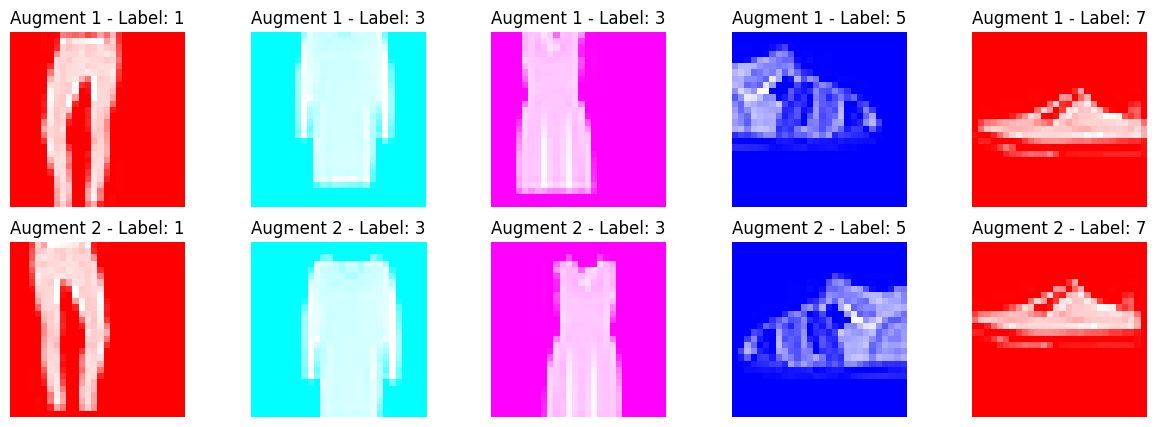

Epoch [1/200]


AttributeError: 'SupervisedContrastiveLoss' object has no attribute 'temperatures'

In [12]:
main()

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import numpy as np
import random
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
seed = 37
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Predefined background colors (RGB values between 0 and 1)
predefined_bg_colors = {
    "red": np.array([1, 0, 0]),
    "green": np.array([0, 1, 0]),
    "blue": np.array([0, 0, 1]),
    "yellow": np.array([1, 1, 0]),
    "purple": np.array([1.0, 0, 1.0]),
    "light blue": np.array([0, 1, 1]),
    "black": np.array([0, 0, 0]),
}

# Convert the dictionary to lists for easier access
color_names = list(predefined_bg_colors.keys())
color_values = np.array(list(predefined_bg_colors.values()))

# Function to colorize FashionMNIST images with background colors
def colorize_fashion_mnist(images, bg_colors):
    colored_images = []
    for img, bg_color in zip(images, bg_colors):
        img = img.squeeze(0)  # Remove the single channel dimension
        img_colored = torch.zeros(3, 28, 28)  # Initialize a colored image (3 channels for RGB)

        # Apply background colors to each channel
        for i in range(3):  # Apply color to each channel
            img_colored[i] = img * img + (1 - img) * bg_color[i]  # Color only the background
        
        colored_images.append(img_colored)
    return torch.stack(colored_images)

# Define transformations for the FashionMNIST dataset
transform_train = transforms.Compose([
    transforms.ToTensor(),
    # You can add normalization or augmentation here if necessary
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    # Add normalization for testing
])

# Load FashionMNIST dataset
fashion_mnist_train = torchvision.datasets.FashionMNIST(root='../../data', train=True, download=True, transform=transform_train)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transform_test)

# Generate random background colors from predefined list
num_samples_train = len(fashion_mnist_train)
bg_color_indices_train = np.random.randint(0, len(predefined_bg_colors), size=num_samples_train)
bg_colors_train = color_values[bg_color_indices_train]  # Get RGB values from predefined colors
bg_color_labels_train = [color_names[idx] for idx in bg_color_indices_train]  # Get color names as labels

# Apply colorization to training images
colored_images_train = colorize_fashion_mnist([img for img, _ in fashion_mnist_train], bg_colors_train)

# Define a custom dataset for Colored FashionMNIST with background color labels
class ColoredFashionMNISTWithBGLabels(torch.utils.data.Dataset):
    def __init__(self, colored_images, labels, bg_color_labels):
        self.colored_images = colored_images
        self.labels = labels
        self.bg_color_labels = bg_color_labels  # Background color labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.colored_images[idx], self.labels[idx], self.bg_color_labels[idx]

# Create train dataset and dataloader
train_dataset = ColoredFashionMNISTWithBGLabels(colored_images_train, [label for _, label in fashion_mnist_train], bg_color_labels_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare test data
num_samples_test = len(fashion_mnist_test)
bg_color_indices_test = np.random.randint(0, len(predefined_bg_colors), size=num_samples_test)
bg_colors_test = color_values[bg_color_indices_test]
bg_color_labels_test = [color_names[idx] for idx in bg_color_indices_test]

# Apply colorization to test images
colored_images_test = colorize_fashion_mnist([img for img, _ in fashion_mnist_test], bg_colors_test)

# Create test dataset and dataloader
test_dataset = ColoredFashionMNISTWithBGLabels(colored_images_test, [label for _, label in fashion_mnist_test], bg_color_labels_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Test colorization and background label generation
for batch_idx, (inputs, digit_labels, bg_color_labels) in enumerate(train_loader):
    print(f"Item Labels: {digit_labels}")
    print(f"Background Color Labels: {bg_color_labels[:10]}")  # Display first 10 background color labels
    break


Item Labels: tensor([0, 6, 5, 9, 5, 2, 8, 8, 9, 0, 9, 4, 0, 6, 6, 3, 3, 8, 7, 9, 0, 7, 2, 0,
        0, 1, 7, 3, 2, 5, 4, 9, 2, 8, 7, 7, 9, 8, 9, 1, 3, 3, 3, 9, 0, 3, 9, 2,
        1, 0, 3, 8, 9, 5, 1, 9, 1, 0, 6, 3, 5, 9, 2, 6])
Background Color Labels: ('black', 'green', 'purple', 'green', 'yellow', 'black', 'black', 'light blue', 'light blue', 'yellow')


In [7]:
# Assuming the necessary imports and model definitions are already done
num_classes = 10
model = get_cnn_contrastive()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = model.to(device)

checkpoint = torch.load("./checkpoint/ckpt_contrastive_12.pth")
model.load_state_dict(checkpoint["net"])

model.freeze_projection()
# Freeze the encoder_t parameters
for param in model.parameters():
    param.requires_grad = False

model.eval()

class EnhancedCNNReconstructorFromY(nn.Module):
    def __init__(self, latent_dim):
        super(EnhancedCNNReconstructorFromY, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 7 * 7)  # More neurons for a better transition from label to image space
        
        # Deconvolution layers to upscale to the original image size
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, y):
        # Convert one-hot encoded label to a high-dimensional representation
        x = F.relu(self.fc(y))
        x = x.view(-1, 128, 7, 7)  # Reshape to match the expected input for the deconvolutional layers

        # Deconvolutions to reconstruct the image
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x_recon = torch.sigmoid(self.deconv4(x))  # Use sigmoid to ensure output is between 0 and 1
        return x_recon

# Initialize the reconstructor for the task
reconstructor_test = EnhancedCNNReconstructorFromY(64).to(device)
optimizer_recon_test = optim.Adam(reconstructor_test.parameters(), lr=1e-4)
criterion_reconstruction = nn.MSELoss()  # You can also try BCE depending on your original setup

# Training loop for the reconstructor
epochs_reconstruction = 20

for epoch in range(epochs_reconstruction):
    reconstructor_test.train()
    total_reconstruction_loss_z1 = 0
    
    for inputs, _,_ in train_loader:
        inputs = inputs.to(device)
        optimizer_recon_test.zero_grad()

        # Get latent representation Z1 from the frozen encoder
        z1 = model._forward_impl_encoder(inputs, 12, True)

        # Reconstruct the image from Z1
        reconstructed = reconstructor_test(z1)

        # Compute reconstruction loss
        reconstruction_loss = criterion_reconstruction(reconstructed, inputs)

        # Backpropagation and optimization
        reconstruction_loss.backward()
        optimizer_recon_test.step()

        total_reconstruction_loss_z1 += reconstruction_loss.item()

    avg_reconstruction_loss_z1 = total_reconstruction_loss_z1 / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs_reconstruction}], Reconstruction Loss from Z1: {avg_reconstruction_loss_z1:.4f}")


NameError: name 'F' is not defined

In [ ]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Variable to accumulate the total SSIM for the entire test set
total_ssim = 0
total_samples = 0

# Set the model to evaluation mode
reconstructor_test.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, targets,_ in test_loader:
        # Move data to the appropriate device
        inputs, targets = inputs.to(device), targets.to(device)

        # One-hot encode the labels (Y)
        z1 = model._forward_impl_encoder(inputs, 12, True)
        # Reconstruct the image from Z1
        reconstructed = reconstructor_test(z1)

        # Move the tensors to CPU and convert to numpy arrays
        inputs_np = inputs.cpu().numpy()
        reconstructed_np = reconstructed.cpu().numpy()

        # Compute SSIM for each sample in the batch and accumulate
        for i in range(inputs_np.shape[0]):
            # Compute SSIM for each image in the batch
            ssim_val = ssim(
                inputs_np[i].transpose(1, 2, 0),
                reconstructed_np[i].transpose(1, 2, 0),
                multichannel=True,
                data_range=inputs_np[i].max() - inputs_np[i].min(),
                win_size=3  # Set win_size to 3 to avoid exceeding image dimensions
            )
            total_ssim += ssim_val
            total_samples += 1

# Compute the average SSIM over the entire test set
avg_ssim = total_ssim / total_samples
print(f'Average SSIM on the Test Set: {avg_ssim:.4f}')


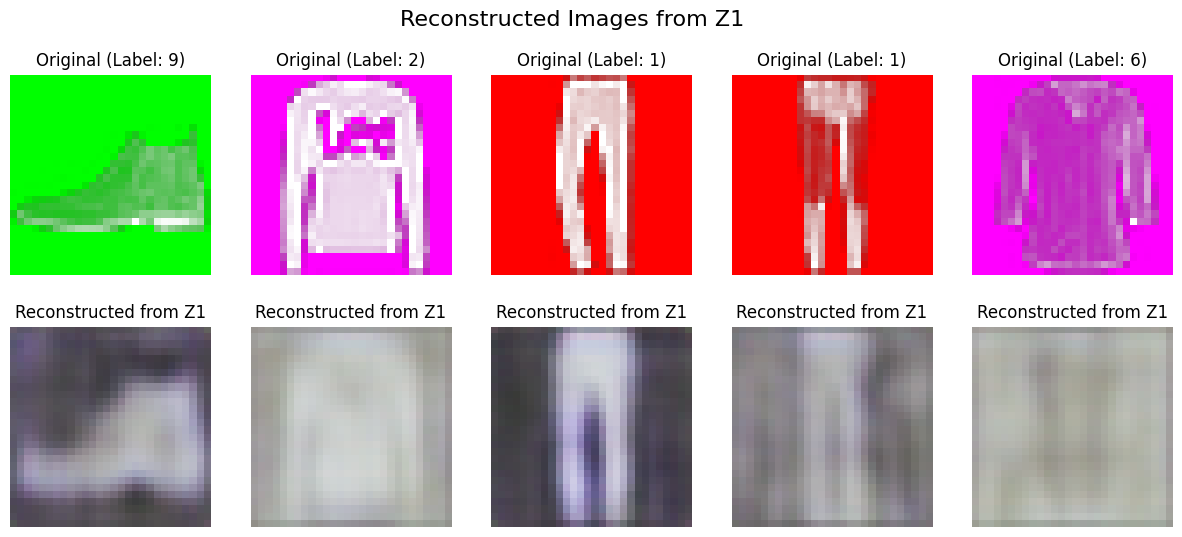

In [29]:

def plot_reconstructed_images(encoder, reconstructor, data_loader, title="Reconstructed Images"):
    encoder.eval()
    reconstructor.eval()
    
    # Fetch a batch of images and labels from the data loader
    data_iter = iter(data_loader)
    images, labels,_ = next(data_iter)
    
    images = images.to(device)
    labels = labels.to(device)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    
    with torch.no_grad():
        for i in range(5):
            # Original image
            original_image = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to NumPy format for plotting
            axes[0, i].imshow(original_image)
            axes[0, i].axis('off')
            axes[0, i].set_title(f"Original (Label: {labels[i].item()})")

            # Reconstruct the image
            z1 = model._forward_impl_encoder(images[i].unsqueeze(0), 12, True)  # Get latent representation Z1
            
            reconstructed_image = reconstructor(z1).cpu().view(3, 28, 28).numpy().transpose(1, 2, 0)
            
            axes[1, i].imshow(reconstructed_image)
            axes[1, i].axis('off')
            axes[1, i].set_title("Reconstructed from Z1")
        
    plt.show()
plot_reconstructed_images(model, reconstructor_test, test_loader, title="Reconstructed Images from Z1")